# Needed Modules

In [287]:
import matplotlib.pyplot as plt
import numpy as np
import re
from typing import List, Dict, Tuple
from sklearn.cluster import AgglomerativeClustering
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw_path
from scipy.cluster.hierarchy import dendrogram
import jsbeautifier
import os
import random

# Configuration

In [288]:
all_recorders = ['salman', 'tarab', 'negin', 'fada', 'rajab']

data_dir = '/Users/bobby/Desktop/Projects/Awesome-Fun-And-Glorious-Gloves-Of-Sign-Language/data/data with new glove'

features_index = {
  # "quat_w": 0,
  # "quat_x": 1,
  # "quat_y": 2,
  # "quat_z": 3,
  # "euler_x": 4,
  # "euler_y": 5,
  # "euler_z": 6,
  "acc_x": 7,
  "acc_y": 8,
  "acc_z": 9,
  "line_acc_x": 10,
  "line_acc_y": 11,
  "line_acc_z": 12,
  "gyro_x": 13,
  "gyro_y": 14,
  "gyro_z": 15,
  "gravity_x": 16,
  "gravity_y": 17,
  "gravity_z": 18,
  "flex_0": 19,
  "flex_1": 20,
  "flex_2": 21,
  "flex_3": 22,
  "flex_4": 23
}

n_features = len(features_index.keys())

index_feature = {value:key for key,value in features_index.items()}

features = np.array([features_index[key] for key in features_index])

labels_map = {
  "Abi": 0,
  "Sabz": 1,
  "Saal": 2,
  "Ruz": 3,
  "Faramush": 4,
  "Ast": 5,
  "Kheili": 6,
  "Tabestun": 7,
  "Bakht": 8,
  "Diruz": 9,
  "Omidvar": 10,
  "Maman": 11,
  "Baba": 12,
  "Khosh": 13,
  "Like": 14,
  "Dislike": 15
}

n_clusters = 16

index_label = {value:key for key,value in labels_map.items()}

# printing
options = jsbeautifier.default_options()
options.indent_size = 2

#pie chart colors
random.seed(42)
colors = {key: (random.random(), random.random(), random.random()) for key in labels_map}

# Loading The Dataset

First we implement a function to exract the label given a file's name:

In [289]:
def extract_file_label(filename: str) -> List[int]:
  filename = filename.split('/')[-1].split('.')[0]
  labels = re.findall('[A-Z][^A-Z]*', filename)
  return [labels_map[label] for label in labels]

extract_file_label('KheiliKheiliAbi.txt')

[6, 6, 0]

Then, we need  a function to read files and extract time series data:

In [290]:
def line2float(line: str, features: np.array = None):
  if features is None:
      return np.array([float(i) for i in line[:-2].split(" ")])
  return np.array([float(i) for i in line[:-2].split(" ")])[features]

def read_file(file:str, features: np.array = None):
    with open(file, "r") as f:
        lines = f.readlines()
    x = [[]]
    for i in range(len(lines)):
        if ";" in lines[i]:
            x.append([])
        else:
            x[-1].append(line2float(lines[i], features=features))
    if x[-1] == []:
        return x[:-1]
    return x

Now we can load the entire dataset:

In [291]:
def load_dataset(data_dir: str, recorders: List[str], features: np.array = None):
  dataset = {}
  for recorder in recorders:
    files = os.listdir(f'{data_dir}/{recorder}')
    if not recorder in dataset:
      dataset[recorder] = []
    for f in files:
      data = read_file(f'{data_dir}/{recorder}/{f}', features=features)
      label = extract_file_label(f)
      for sample in data:
        dataset[recorder].append((np.array(sample), label))
  return dataset

dataset = load_dataset(data_dir, all_recorders, features=features)
for recorder in all_recorders:
  print(recorder, len(dataset[recorder]))

salman 616
tarab 807
negin 355
fada 382
rajab 404


# Removing outliers

We observe that there are some outlier data that may cause problem in our normalization process:
- quat_y > 1.5
- euler_x > 500 or < -500
- acc_x > 100 or < -100
- acc_z > 100 or < -100
- gyro_z > 20
- gravity_y > 11

Lets see to what sample does these outliers belong:

In [292]:
# outlier_bt = {'quat_y': 1.5, 'euler_x': 500, 'acc_x': 100, 'acc_z': 100, 'gyro_z': 20, 'gravity_y': 11}
# outlier_bt = {'euler_x': 500, 'acc_x': 100, 'acc_z': 100, 'gyro_z': 20, 'gravity_y': 11}
# outlier_lt = {'euler_x': -500, 'acc_x': -100, 'acc_z': -100}

# outlier_bt = {'gyro_z': 20, 'gravity_y': 11}

outlier_bt = {'acc_x': 100, 'acc_z': 100, 'gyro_z': 20, 'gravity_y': 11}
outlier_lt = {'acc_x': -100, 'acc_z': -100}

index_relative_feature = {key : i for i, key in enumerate(features_index.keys())}

outlier_ids = dict()

for recorder in all_recorders:
  for id, sample_label_pair in enumerate(dataset[recorder]):
      sample, label = sample_label_pair
      for feature in outlier_bt:
         index = index_relative_feature[feature]
         for i in range(sample.shape[0]):
            if sample[i, index] > outlier_bt[feature]:
               print('Bigger:', recorder, id, feature, sample[i, index], label)
               if recorder not in outlier_ids:
                  outlier_ids[recorder] = []
               outlier_ids[recorder].append(id)
               break
      
      for feature in outlier_lt:
         index = index_relative_feature[feature]
         for i in range(sample.shape[0]):
            if sample[i, index] < outlier_lt[feature]:
               print('Smaller:', recorder, id, feature, sample[i, index], label)
               if recorder not in outlier_ids:
                  outlier_ids[recorder] = []
               outlier_ids[recorder].append(id)
               break

print(outlier_ids)

Smaller: salman 267 acc_z -320.45 [9, 1]
Bigger: salman 280 gyro_z 36.01 [8, 4]
Bigger: salman 366 gravity_y 38.9 [5, 1]
Bigger: salman 475 acc_x 163.71 [3, 0, 2]
Bigger: tarab 577 acc_z 322.91 [6, 8, 1]
Smaller: tarab 654 acc_x -322.89 [10, 4]
{'salman': [267, 280, 366, 475], 'tarab': [577, 654]}


Now lets remove those outliers:

In [293]:
def delete_items_from_list(the_list: list, indexes: List[int]):
  for index in sorted(indexes, reverse=True):
        del the_list[index]
      
for recorder, ids in outlier_ids.items():
      delete_items_from_list(dataset[recorder], ids)
          
for recorder in all_recorders:
  print(recorder, len(dataset[recorder]))

salman 612
tarab 805
negin 355
fada 382
rajab 404


Lets find the minimum and maximum range of each feature to use it our normalization process:

In [294]:
mins = np.ones((1, n_features), dtype=float) * (10 ** 6)
maxs = np.ones((1, n_features), dtype=float) * (-10 ** 5)

for _ , samples in dataset.items():
  for sample_label_pair in samples:
    sample, _ = sample_label_pair
    data_mins = np.min(sample, axis = 0, keepdims = True)
    data_maxs = np.max(sample, axis = 0, keepdims = True)
    mins = np.minimum(mins, data_mins)
    maxs = np.maximum(maxs, data_maxs)

print(mins)
print(maxs)

[[-39.2    -26.23   -38.68   -39.4    -17.21   -34.64   -13.3511 -28.8367
  -11.6756  -9.35    -9.8     -9.8      0.       5.     123.       5.
   97.    ]]
[[ 39.41    39.97    39.87    30.03    30.95    43.13    16.2378  29.8933
   19.7389   9.8      9.18     9.8    405.     613.     493.     568.
  380.    ]]


# Clustering 1-word samples

First, we implement a function to filter the dataset:

In [295]:
def filter_dataset(dataset: Dict[str, List[Tuple[np.array, np.array]]], recorders: List[str],
                    max_word_length: int, min_word_length: int  = 1):
  labels = []
  series = []
  series_recorders = []
  for recorder in recorders:
    for sample_label_pair in dataset[recorder]:
        sample, label = sample_label_pair
        if min_word_length <= len(label) <= max_word_length:
          sample_np = (np.array(sample) - mins) / (maxs - mins)
          series.append(sample_np.tolist())
          labels.append(label)
          series_recorders.append(recorder)

  return series, labels, series_recorders

In [296]:
def my_dtw(series1, series2, r1=3, r2=3):

    def euclidean_dist(sample1, sample2):
        return np.sum(np.power(np.array(sample1) - np.array(sample2), 2))
    
    # distances = np.zeros((len(series1) + 1, len(series2) + 1), dtype=np.float64)
    distances = np.ones((len(series1) + 1, len(series2) + 1), dtype=np.float64) * np.inf
    directions = np.zeros((len(series1) + 1, len(series2) + 1), dtype=np.int8)

    for i in range(r1 + 1):
        distances[i, 0] = 0
        directions[i, 0] = 2
    
    for j in range(r2 + 1):
        distances[0, j] = 0
        directions[0, j] = 3

    for i in range(1, distances.shape[0]):
        for j in range(1, distances.shape[1]):
            min_value = distances[i - 1, j - 1]
            directions[i, j] = 1
            if distances[i - 1, j] < min_value:
                min_value = distances[i - 1, j]
                directions[i, j] = 2
            if distances[i, j - 1] < min_value:
                min_value = distances[i, j - 1]
                directions[i, j] = 3

            distances[i, j] = min_value + euclidean_dist(series1[i - 1], series2[j - 1])

    #p = (distances.shape[0] - 1, distances.shape[1] - 1)
    min_row_value = float('inf')
    min_col_value = float('inf')
    min_row_point = None
    min_col_point = None
    n, m = distances.shape[0] - 1, distances.shape[1] - 1
    for i in range(r1 + 1):
        if distances[n - i, m] < min_col_value:
            min_col_point = (n - i, m)
            min_col_value = distances[n - i, m]

    for j in range(r2 + 1):
        if distances[n, m - j] < min_row_value:
            min_row_point = (n, m - j)
            min_row_value = distances[n, m - j]
    
    p = min_col_point if min_col_value < min_row_value else min_row_point
    final_point = p
    points = []
    while p[0] > r1 or p[1] > r2:   
        points.append((p[0] - 1, p[1] - 1))
        if directions[p[0], p[1]] == 1:
            p = (p[0] - 1, p[1] - 1)
        elif directions[p[0], p[1]] == 2:
            p = (p[0] - 1, p[1])
        elif directions[p[0], p[1]] == 3:
            p = (p[0], p[1] - 1)
        
    
    points.reverse()
    return distances[final_point[0], final_point[1]], distances[1:, 1:], points

### 1.Based on the data belonging to a specific recorder

Now we can perform clustering on data belonging to a recorder (here recorder = salman):

In [297]:
target_recorders = ['salman']
series, labels, series_recorders = filter_dataset(dataset, target_recorders, max_word_length=1)

# pairwise distances
distances = np.zeros((len(series), len(series)), dtype=np.float64)
for i in range(len(series) - 1):
    for j in range(i + 1, len(series)):
        # dist = dtw_path(series[i], series[j])[1]
        dist = my_dtw(series[i], series[j])[0]
        distances[i,j] = dist
        distances[j,i]= dist

agg = AgglomerativeClustering(n_clusters=16, affinity='precomputed',
                              linkage='complete')

cls_pred = agg.fit_predict(distances)

This is the clustering result:

In [298]:
def get_clustering_result(clustering_labels: np.array, actual_labels: np.array):
    clustering_results = {}

    for i, cluster_num in enumerate(clustering_labels):
        if str(cluster_num) not in clustering_results:
            clustering_results[str(cluster_num)] = []
        clustering_results[str(cluster_num)].append(int(actual_labels[i]))
        
    return clustering_results

clustering_results = get_clustering_result(cls_pred, np.array(labels))

Now we can observe the purity of clusters:

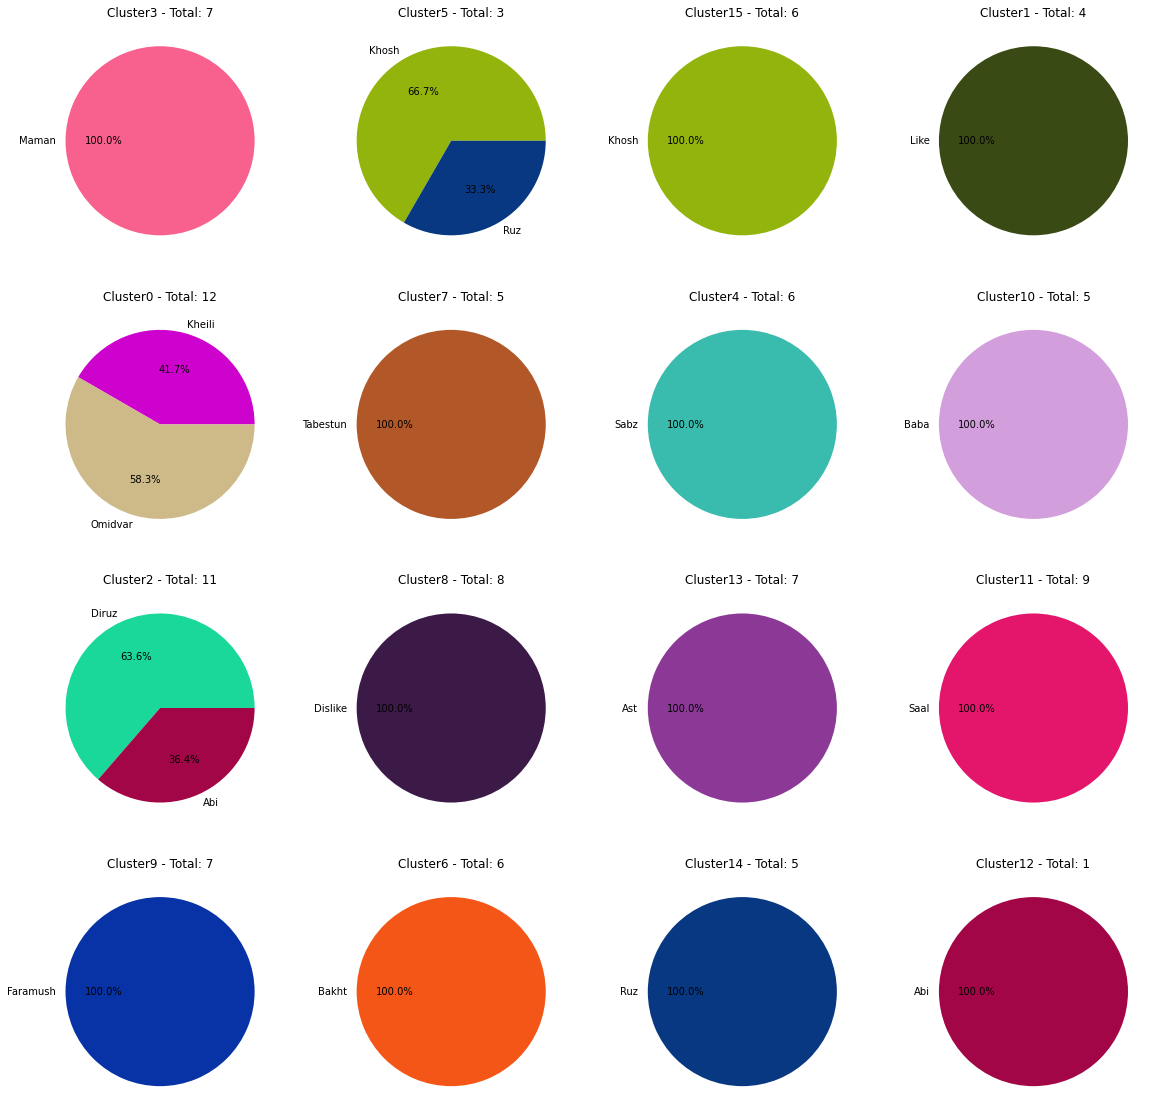

Average entropy:  0.244


In [299]:
from collections import Counter
import math

def get_cluster_stats(items_list: List[int]):
    stats = Counter(items_list)
    entropy = 0
    for key in stats:
        stats[key] /= len(items_list)
        entropy += -stats[key] * math.log2(stats[key])
    return stats, entropy

def plot_clustering_distributions(clustering_results: Dict[str, List[int]], cols=4, colors=colors):
    n_clusters = len(clustering_results.keys())
    rows = n_clusters // cols
    _, ax = plt.subplots(rows, cols, figsize = (rows * 5, cols * 5))
    avg_entropy = 0
    for i, cluster in enumerate(clustering_results.keys()):
        cluster_stats, entropy = get_cluster_stats(clustering_results[cluster])
        avg_entropy += entropy * len(clustering_results[cluster])
        pie_labels = []
        pie_y = []
        for key, value in cluster_stats.items():
            pie_y.append(value)
            pie_labels.append(index_label[key])
        pie_colors = [colors[pie_label] for pie_label in pie_labels]
        pie_y = np.array(pie_y)
        ax[i // cols, i % cols].pie(pie_y, labels = pie_labels, autopct='%1.1f%%', colors=pie_colors)
        ax[i // cols, i % cols].set_title(f'Cluster{cluster} - Total: {len(clustering_results[cluster])}')
    avg_entropy = avg_entropy / len(labels)
    plt.show()
    return avg_entropy

avg_entropy = plot_clustering_distributions(clustering_results)
print('Average entropy: ', round(avg_entropy, 3))
plt.show()

Finally, we can see the the data label-wise:

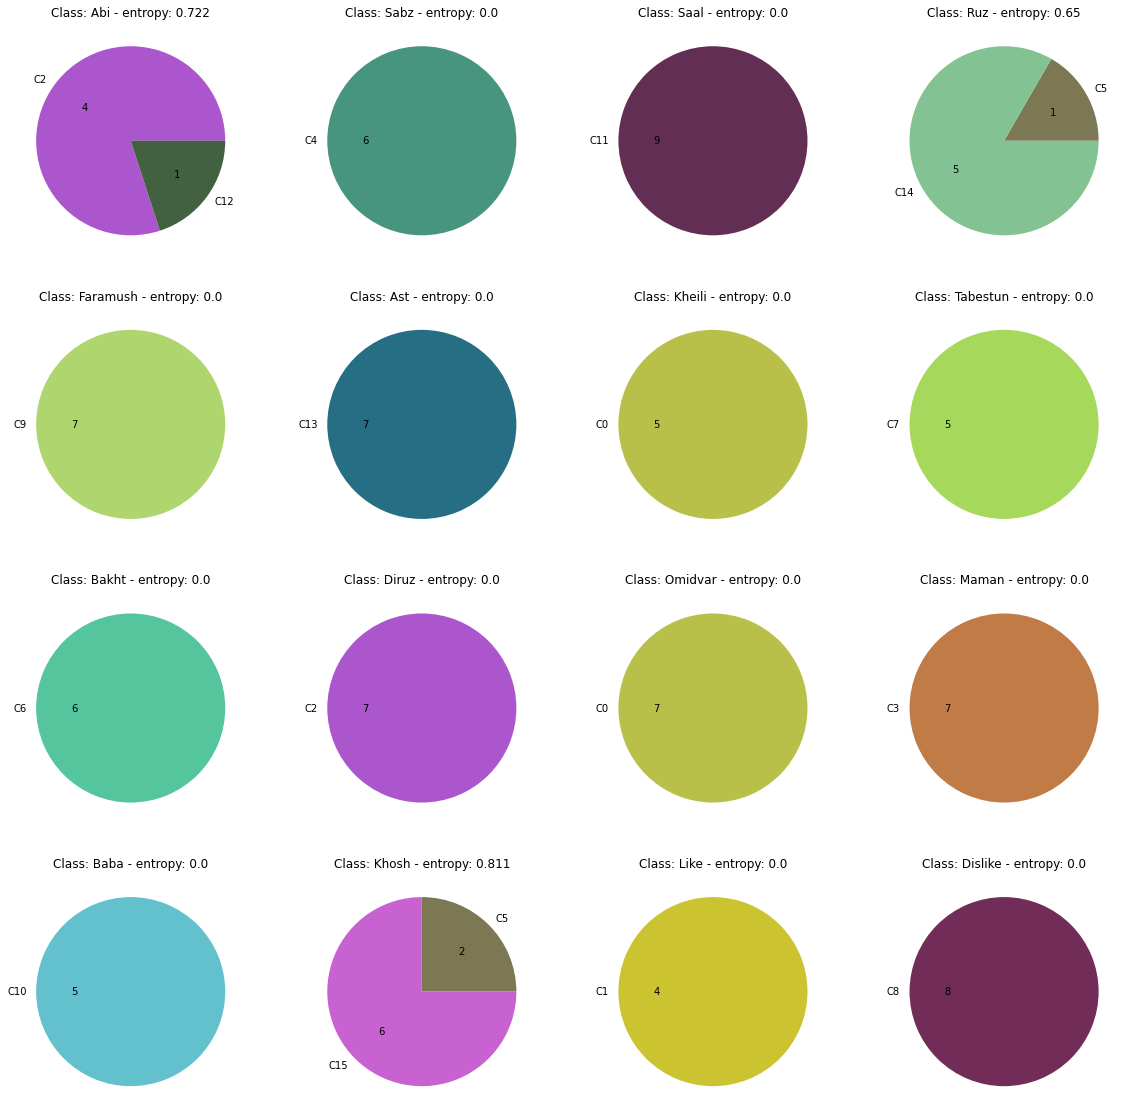

Avg entropy 0.137


In [300]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

def plot_labels_distribution(clustering_results: Dict[str, List[int]], index_label: Dict[int, str], cols=4):
    # Assign a color to each cluster
    clustering_colors = {key: (random.randint(30, 220) / 255, random.randint(30, 220) / 255, random.randint(30, 220) / 255) for key in clustering_results}
    # Create the plot
    n_labels = len(index_label.keys())
    rows = n_labels // cols
    _, ax = plt.subplots(rows, cols, figsize = (rows * 5, cols * 5))
    # init variables
    avg_entropy = 0
    total_count = 0
    # loop over index_label dict to count total items of a label and its stats
    for i, l_index in enumerate(index_label.keys()):
        label_count = 0
        label_stats = {}
        # Counting items of a label and save how many items we have in each cluster for the given labe;
        for cluster, items in clustering_results.items():
            count = items.count(l_index)
            if count != 0:
                label_stats[cluster] = count
                label_count += count
        # calculate the entropy
        class_entropy = 0
        for key in label_stats:
            prob = label_stats[key] / label_count
            class_entropy += -prob * math.log2(prob)
        avg_entropy += class_entropy * label_count
        total_count += label_count
        # plot the result
        pie_clusters = []
        pie_value = []
        for key, value in label_stats.items():
            pie_value.append(value)
            pie_clusters.append(key)
        pie_colors = [clustering_colors[pie_cluster] for pie_cluster in pie_clusters]
        pie_clusters = list(map(lambda x: f'C{x}', pie_clusters))
        pie_value = np.array(pie_value)
        ax[i // 4, i % 4].pie(pie_value, labels = pie_clusters, autopct=autopct_format(pie_value), colors=pie_colors)
        ax[i // 4, i % 4].set_title(f'Class: {index_label[l_index]} - entropy: {round(class_entropy, 3)}')
    
    plt.show()
    avg_entropy /= total_count
    return avg_entropy

avg_entropy = plot_labels_distribution(clustering_results, index_label, cols=4)
print('Avg entropy', round(avg_entropy, 3))
plt.show()


### 2.Based on the data belonging to all recorders

We do the same, but with target_recorders = all_recorders:

In [301]:
target_recorders = all_recorders
series, labels, series_recorders = filter_dataset(dataset, target_recorders, max_word_length=1)

# pairwise distances
distances = np.zeros((len(series), len(series)), dtype=np.float64)
for i in range(len(series) - 1):
    for j in range(i + 1, len(series)):
        # dist = dtw_path(series[i], series[j])[1]
        dist = my_dtw(series[i], series[j])[0]
        distances[i,j] = dist
        distances[j,i]= dist

agg = AgglomerativeClustering(n_clusters=16, affinity='precomputed',
                              linkage='complete')

cls_pred = agg.fit_predict(distances)

Here is the purity of clusters:

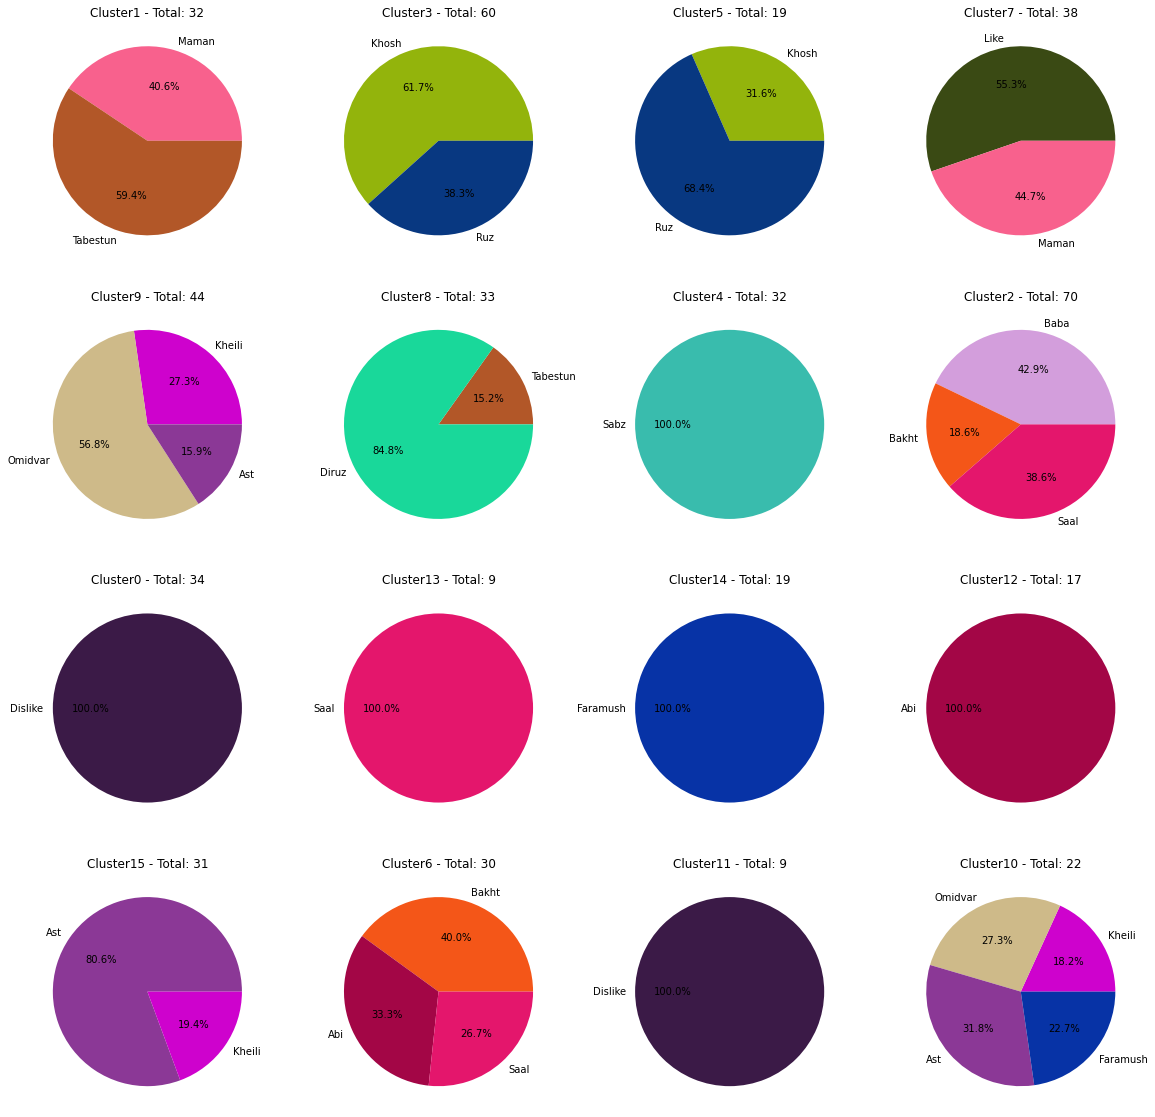

Average entropy:  0.888


In [302]:
clustering_results = get_clustering_result(cls_pred, np.array(labels))
avg_entropy = plot_clustering_distributions(clustering_results)
print('Average entropy: ', round(avg_entropy, 3))
plt.show()

And finally, we can see the the data label-wise:

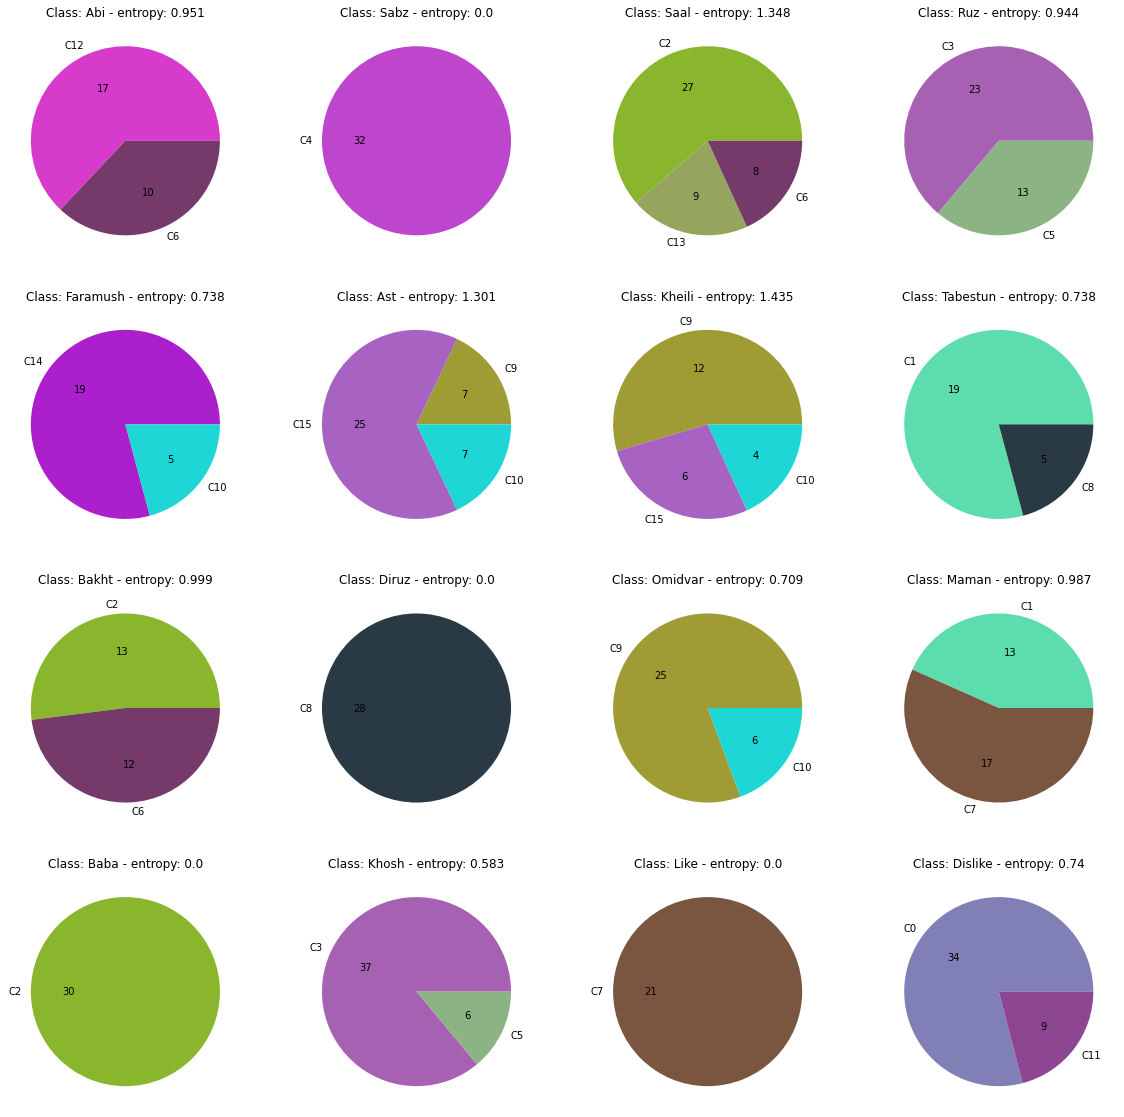

Avg entropy 0.742


In [303]:
avg_entropy = plot_labels_distribution(clustering_results, index_label, cols=4)
print('Avg entropy', round(avg_entropy, 3))
plt.show()